In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import tadasets
from ripser import Rips
import persim
import seaborn as sns
from sklearn.cluster import KMeans
from gtda.time_series import SlidingWindow

In [3]:
def traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,percentage=0,plot=1):
  def F(x):
    v,w = x
    dv  = v - (v**3)/3 - w + Iext
    dw  = epsilon*(v + a - b*w)
    return np.array([dv,dw])

  def J(x):
    v,w = x
    J11 = 1 - theta*dt*(1-v**2)
    J12 = dt*theta
    J21 = -dt*theta*epsilon
    J22 = 1 + dt*theta*b*epsilon
    return np.array([[J11,J12],[J21,J22]])

  def Newton(x,f,maxit,tol):
    i = 0
    converged = False
    x_old = x.copy()

    def g(x_current):
      return x_current - f(x_current)

    while not converged:
      i += 1
      Jacobian_g = J(x_old)
      delta_x = np.linalg.solve(Jacobian_g, -g(x_old))
      x_new = x_old + delta_x
      if i >= maxit or np.linalg.norm(g(x_new)) < tol or np.linalg.norm(delta_x) < tol:
          converged = True
      else:
          x_old = x_new.copy()

    return x_new

  tt    = np.arange(0,T,dt)
  x     = np.array([v0,w0])

  x_old = x.copy()
  for t in tt[1:]:
    C = x_old + dt*(1-theta)*F(x_old)
    def RHS(x):
      return C + dt*theta*F(x)
    x_new = Newton(x_old,RHS,10,1e-7)
    x = np.vstack((x,x_new))
    x_old = x_new.copy()

  if plot == 1:
    plt.figure(figsize=(5, 3))
    plt.plot(tt, x[:, 0], label='v', color='c')
    plt.plot(tt, x[:, 1], label='w', color='y')
    v_plot = np.min(x[:,0]) + percentage*(np.max(x[:,0]) - np.min(x[:,0]))
    w_plot = np.min(x[:,1]) + percentage*(np.max(x[:,1]) - np.min(x[:,1]))
    plt.hlines(v_plot, xmin=0, xmax=T, color='c', linestyles='dashed', label='v_plot')
    plt.hlines(w_plot, xmin=0, xmax=T, color='y', linestyles='dashed', label='w_plot')
    plt.xlabel('Time (tt)')
    plt.ylabel('Values (v, w)')
    plt.title('Plot of v and w against Time')
    plt.legend()
    plt.grid(True)
    plt.show()

  return x

def check_limit_cycle(trajectory):
	check_v = 3/4*np.max(trajectory[:, 0])
	check_w = 3/4*np.max(trajectory[:, 1])
	num_v   = 0
	num_w   = 0
	epsilon = 0
		
	for i in range(trajectory.shape[0] - 1):
		epsilon += np.abs(trajectory[i, 0] - trajectory[i + 1, 0]) + np.abs(trajectory[i, 1] - trajectory[i + 1, 1])
	epsilon /= 2*(trajectory.shape[0] - 1)

	for i in range(trajectory.shape[0]):
		if np.abs(trajectory[i, 0]-check_v)<epsilon:
			num_v += 1
		if np.abs(trajectory[i, 1]-check_w)<epsilon:
			num_w += 1

	if num_v > 2 and num_w > 2:
		return True
	else:
		return False
     
def plot_trajectory(trajectory,t0,tf):
	tt = np.linspace(t0, tf, trajectory.shape[0])
	plt.figure(figsize=(5, 3))
	plt.plot(tt,trajectory[:, 0], label='v(t)')
	plt.plot(tt,trajectory[:, 1], label='w(t)')
	plt.xlabel('Time')
	plt.ylabel('Values (v, w)')
	plt.title('v and w over time')
	plt.legend()
	plt.grid(True)
	plt.show()

def extract_persistence(trajectory, rips):
	out = [0.0, 0.0]
	dgm = rips.transform(trajectory)

	temp = dgm[0]
	temp = temp[:,1] - temp[:,0]
	temp.sort()
	out[0] = temp[-2]

	temp = dgm[1]
	temp = temp[:,1] - temp[:,0]
	temp.sort()
	if temp.shape[0] > 0:
		out[1] = temp[-1]
	else:
		out[1] = 0
			
	return out

In [4]:
theta = 1
T     = 100
N     = 500
dt    = T/N
NT    = 100

percentage = 0.5

v0      = 1.5
w0      = v0

rips         = Rips(verbose=False)
persistences = []

trajectories = []
parameters   = []

upper_limit = 1

for i in range(1,NT+1):
	epsilon = np.random.uniform(0.0,upper_limit) #np.random.uniform(0.0,1.2)
	a       = np.random.uniform(0.1,upper_limit) #np.random.uniform(0.1,1.0)
	b       = np.random.uniform(0.1,upper_limit) #np.random.uniform(0.1,1.0)
	Iext    = np.random.uniform(0.2,upper_limit) #np.random.uniform(0.2,1.4)

	x_temp = traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,percentage,i%500==0)
	trajectories.append(x_temp)
	#per = extract_persistence(x_temp[::3,:], rips)
	#persistences.append(per[1])
	parameters.append([epsilon,a,b,Iext])

training_target = np.stack(trajectories, axis=0).astype(np.float64)
parameters      = np.stack(parameters, axis=0).astype(np.float64)

#print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/total_trajectories)*100,"%")

(100, 2)


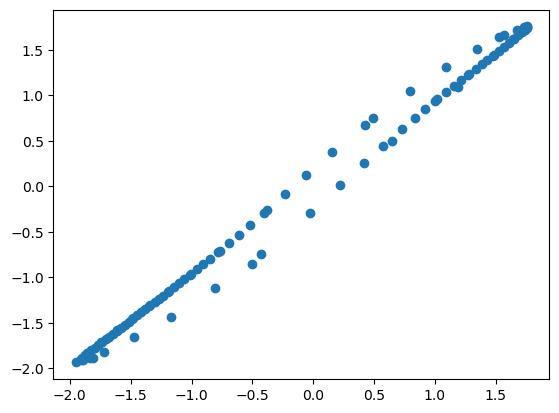

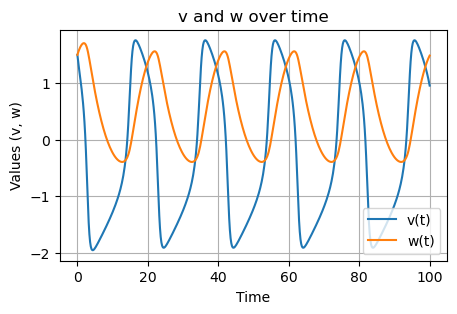

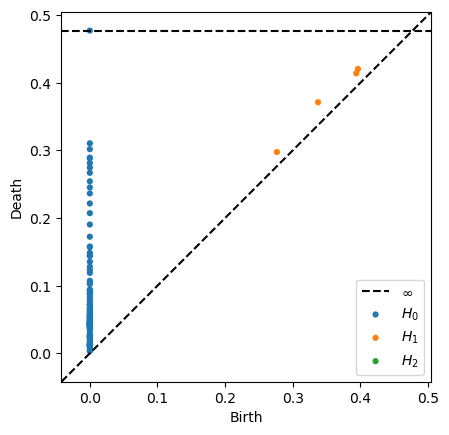

In [9]:
windows   = SlidingWindow(size=2, stride=5)
i = 1
X_windows = windows.fit_transform(training_target[i,:,0])
print(X_windows.shape)
plt.scatter(X_windows[:,0], X_windows[:,1])
plot_trajectory(training_target[i,:,:],0,T)
rips = Rips(verbose=False, maxdim=2)
p1 = rips.transform(X_windows)
rips.plot(p1)

In [ ]:
prova = np.linspace(0,20,100)
plt.plot(prova)
X_windows = windows.fit_transform(prova)
X_windows.shape
plt.figure()
plt.scatter(X_windows[:,0], X_windows[:,1])

In [ ]:
mean_per = (np.max(persistences) + np.min(persistences))/2
counts, bins = np.histogram(persistences, bins=50)
plt.stairs(counts, bins)
plt.vlines(mean_per, ymin=0, ymax=max(counts), colors='r', linestyles='dashed', label='Mean Persistence')

In [ ]:
persistences = np.array(persistences).reshape(-1,1)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(np.array(persistences))
kmeans.labels_

In [ ]:
for i in range(100):
    plot_trajectory(training_target[i,:,:],0,T)
    print(kmeans.labels_[i])

In [ ]:
persistences[3]

In [ ]:
rips = Rips(verbose=False)

i = 0
plot_trajectory(training_target[i,:,:], 0, T)
print(check_limit_cycle(training_target[i,:,:]))

plt.figure(figsize=(5, 3))
plt.plot(training_target[i,:,0],training_target[i,:,1], label='phase space')
plt.xlabel('v(t)')
plt.ylabel('w(t)')
plt.title('Phase Space Trajectory')
plt.grid(True)
plt.show()

p1 = rips.transform(training_target[i,:,:])
rips.plot(p1)

plot_trajectory(training_target[i,::3,:], 0, T)
print(check_limit_cycle(training_target[i,:,:]))

plt.figure(figsize=(5, 3))
plt.plot(training_target[i,::3,0],training_target[i,::3,1], label='phase space')
plt.xlabel('v(t)')
plt.ylabel('w(t)')
plt.title('Phase Space Trajectory')
plt.grid(True)
plt.show()

p2 = rips.transform(training_target[i,::3,:])
rips.plot(p2)

In [ ]:
cycle_persistence    = np.empty((0,2))
no_cycle_persistence = np.empty((0,2))

rips = Rips(verbose=False)

for i in range(training_target.shape[0]):
	if(check_limit_cycle(training_target[i,:,:])):
		cycle_persistence= np.append(cycle_persistence, extract_persistence(training_target[i,:,:],rips), axis=0)
	else:
		no_cycle_persistence=np.append(no_cycle_persistence, extract_persistence(training_target[i,:,:],rips), axis=0)

In [ ]:
p1 = cycle_persistence[:,1]
p2 = no_cycle_persistence[:,1]

sns.kdeplot(p1, label='Limit cycle', fill=True, alpha=0.5)
sns.kdeplot(p2, label='No limit cycle', fill=True, alpha=0.5)

plt.xlabel('Persistence')
plt.ylabel('Distribution')
plt.legend(title='Classe')
plt.title('H^1 Persistence Distribution')
plt.show()

In [ ]:
cycle_persistence_sliced    = np.empty((0,2))
no_cycle_persistence_sliced = np.empty((0,2))

p = 2

rips = Rips(verbose=False)

for i in range(training_target.shape[0]):
	if(check_limit_cycle(training_target[i,:,:])):
		cycle_persistence_sliced= np.append(cycle_persistence_sliced, extract_persistence(training_target[i,::p,:],rips), axis=0)
	else:
		no_cycle_persistence_sliced=np.append(no_cycle_persistence_sliced, extract_persistence(training_target[i,::p,:],rips), axis=0)

In [ ]:
p1s = cycle_persistence_sliced[:,1]
p2s = no_cycle_persistence_sliced[:,1]

sns.kdeplot(p1s, label='Limit cycle', fill=True, alpha=0.5)
sns.kdeplot(p2s, label='No limit cycle', fill=True, alpha=0.5)

plt.xlabel('Persistence')
plt.ylabel('Distribution')
plt.legend(title='Classe')
plt.title('H^1 Persistence Distribution')
plt.show()

In [ ]:
distance = 0

for i in range(training_target.shape[0]):
    distance += persim.wasserstein(rips.transform(training_target[i,:,:])[1], rips.transform(training_target[i,::3,:])[1], matching=False)
distance /= training_target.shape[0]
print(distance)

In [ ]:
distance = 0

for i in range(training_target.shape[0]):
    distance += persim.wasserstein(rips.transform(training_target[i,:,:])[1], rips.transform(training_target[i,::2,:])[1], matching=False)
distance /= training_target.shape[0]
print(distance)

In [ ]:
p1 = cycle_persistence[:,0]
p2 = no_cycle_persistence[:,0]

sns.kdeplot(p1, label='Limit cycle', fill=True, alpha=0.5)
sns.kdeplot(p2, label='No limit cycle', fill=True, alpha=0.5)

plt.xlabel('Persistence')
plt.ylabel('Distribution')
plt.legend(title='Classe')
plt.title('H^0 Persistence Distribution')
plt.show()

In [ ]:
prova1 = rips.transform(training_target[0,:,:])
prova2 = rips.transform(training_target[0,::3,:])
plt.subplot(1, 2, 1)
rips.plot(prova1, show=False)
plt.subplot(1, 2, 2)
rips.plot(prova2, show=False)

print(persim.bottleneck(prova1[1], prova2[1], matching=False))

# TDA tools experiments

In [ ]:
from ripser import Rips

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

rips = Rips()
dgm  = rips.transform(training_target[0,:,:])
rips.plot(show=True, title=f"Noisy\n{diagram_sizes(dgm)}")

In [ ]:
data_clean = tadasets.dsphere(d=1, n=10, noise=0.0)
plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data", s=8)
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
rips = Rips()
dgm  = rips.transform(data_clean)
rips.plot(show=True, title=f"Noisy\n{diagram_sizes(dgm)}")

In [ ]:
H0 = dgm[0]
persistences = H0[:,1] - H0[:,0]
persistences.sort()
np.max(persistences[:-1])

In [ ]:
from persim import PersLandscapeApprox, PersLandscapeExact
from persim.landscapes import plot_landscape_simple

pla = PersLandscapeApprox(dgms=dgm,hom_deg=0)
ax = plot_landscape_simple(pla, depth_range=range(10))